# Feature Analysis Demo with scFeatureLens

This notebook demonstrates how to use the hypothesis generation and visualization tools from `scFeatureLens` to analyze and interpret features in single-cell embeddings.

We'll cover:
1. Loading embeddings and SAE models
2. Visualizing SAE features in embedding space
3. Identifying differential features between cell types
4. Analyzing GO term enrichment 
5. Predicting and visualizing embedding changes with feature perturbation

The used data and model are from the paper (multiDGD embeddings and data of human bone marrow).

In [1]:
# Import required libraries
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
from sklearn.decomposition import PCA

# Import scFeatureLens modules
from tools.scFeatureLens.sae import SparseAutoencoder
from tools.scFeatureLens.hypothesis import predict_embedding_change, get_differential_features
from tools.scFeatureLens.viz import (
    compute_go_feature_matrix,
    add_parent_go_terms, 
    visualize_go_feature_space,
    probe_go_terms,
    visualize_feature_in_embedding,
    visualize_feature_perturbation
)

# Set up paths and device
data_dir = "../../data"
results_dir = "../../results"
models_dir = os.path.join(results_dir, "models")
figures_dir = os.path.join(results_dir, "figures")
reports_dir = os.path.join(results_dir, "reports")

data_name = "human_bonemarrow_filtered.h5ad"
embeddings_name = "human_bonemarrow_multidgd_reps.pt"
model_name = "sae_model_10000_l1-1e-3_lr-1e-4_500epochs.pt"
results_name = "sc_dgd_sae_go_analysis_all.csv"
activations_name = None

os.makedirs(figures_dir, exist_ok=True)
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 1. Load Data and Models

First, let's load our data, embeddings, and pre-trained SAE model.

In [2]:
# Load data
# This example assumes you have an AnnData object, embeddings, and SAE model
# Adjust paths as needed for your environment

data = ad.read_h5ad(os.path.join(data_dir, data_name))
print(f"Loaded data with {data.shape[0]} cells and {data.shape[1]} genes")

# Load embeddings
embeddings = torch.load(os.path.join(data_dir, embeddings_name))
print(f"Loaded embeddings with shape: {embeddings.shape}")

# Load or create SAE model
input_size = embeddings.shape[1]
hidden_size = 10000  # Number of SAE features

# Try to load pre-trained SAE model
sae_model_path = os.path.join(models_dir, model_name)
sae_model = SparseAutoencoder(input_size, hidden_size)

sae_model.load_state_dict(torch.load(sae_model_path, weights_only=False, map_location=device))
sae_model.to(device)
print("Loaded pre-trained SAE model")

# Try to load pre-computed activations
if activations_name is not None:
    activations = torch.load(os.path.join(reports_dir, "sae_activations.pt"))
    print(f"Loaded pre-computed activations with shape: {activations.shape}")
else:
    with torch.no_grad():
        embeddings_tensor = embeddings.to(device)
        _, activations = sae_model(embeddings_tensor)
        activations = activations.cpu()
    print(f"Computed activations with shape: {activations.shape}")

Loaded data with 56714 cells and 13431 genes
Loaded embeddings with shape: torch.Size([56714, 20])
Loaded pre-trained SAE model
Computed activations with shape: torch.Size([56714, 10000])
Computed activations with shape: torch.Size([56714, 10000])


## 2. Visualize SAE Features in Embedding Space

Let's visualize how specific SAE features are distributed in the embedding space.

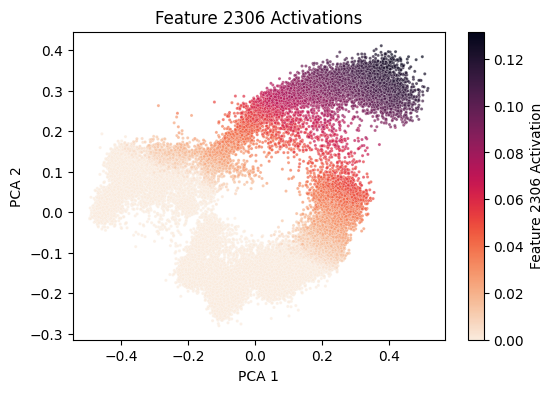

In [4]:
# Choose a feature to visualize
feature_idx = 2306  # Replace with a feature of interest

# Visualize the feature in embedding space
fig, ax, df_plot = visualize_feature_in_embedding(
    embeddings=embeddings,
    feature_idx=feature_idx,
    activations=activations,
    method='pca',  # Can also use 'umap'
    figsize=(6, 4),
    cmap='rocket_r',
    random_state=42,
    device=device,
    output_path=os.path.join(figures_dir, f"feature_{feature_idx}_embedding.png")
)

plt.show()

## 3. Find Differential Features Between Cell Groups

If we have cell type annotations or other grouping information, we can identify which features differentiate between groups.

Top differential features:
      feature  mean_group1  mean_group2      diff  abs_diff  t_statistic  \
4525     4525     0.037478     0.089342  0.051865  0.051865  -125.765018   
7602     7602     0.000617     0.045937  0.045320  0.045320  -154.545894   
2306     2306     0.059411     0.103825  0.044414  0.044414  -107.411986   
2129     2129     0.039454     0.082080  0.042627  0.042627  -123.769979   
8048     8048     0.011585     0.049370  0.037785  0.037785  -116.239695   
5793     5793     0.011586     0.047328  0.035741  0.035741  -135.577217   
7651     7651     0.001023     0.036348  0.035325  0.035325  -116.574543   
6337     6337     0.000254     0.035093  0.034840  0.034840  -151.379656   
3191     3191     0.003237     0.036838  0.033602  0.033602  -104.049470   
2631     2631     0.004323     0.036969  0.032646  0.032646   -87.610065   

      p_value  effect_size  
4525      0.0     4.560544  
7602      0.0     6.000801  
2306      0.0     3.809656  
2129      0.0     4.

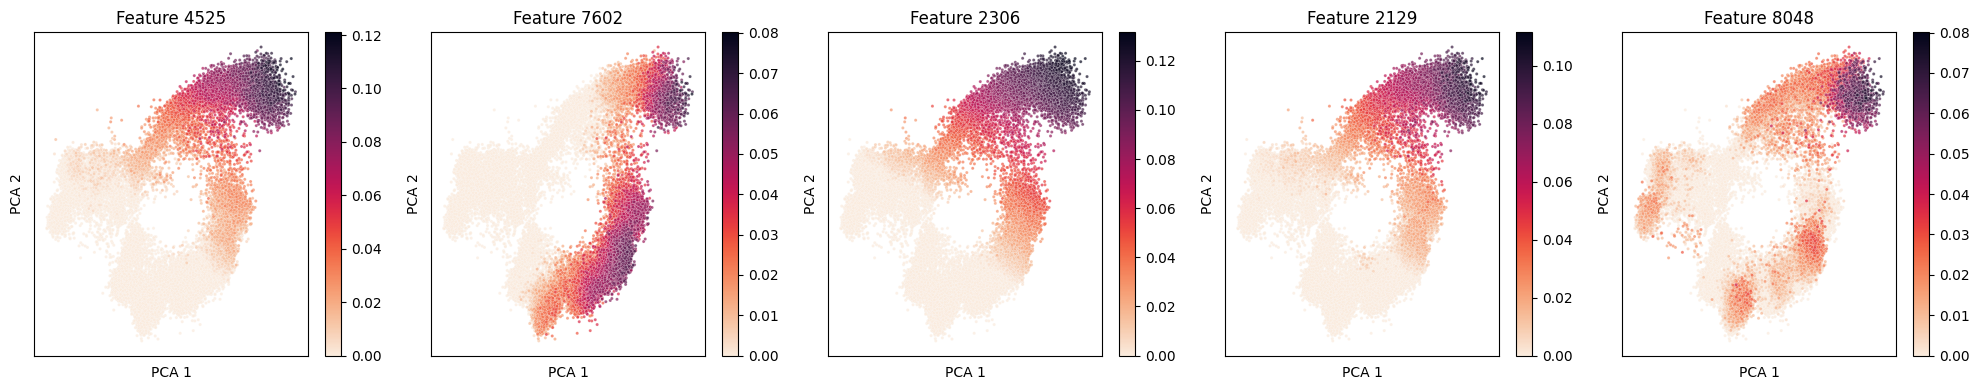

In [3]:
# Define two cell groups for comparison
# In practice, these could be different cell types, treatment conditions, etc.
obs_key = "cell_type"
ct1 = 'Proerythroblast'
ct2 = 'Normoblast'

group1_indices = np.where(data.obs['cell_type'] == ct1)[0]
group2_indices = np.where(data.obs['cell_type'] == ct2)[0]

# Find differential features between the two groups
diff_features = get_differential_features(
    embeddings=embeddings,
    cell_indices_1=group1_indices,
    cell_indices_2=group2_indices,
    sae_model=sae_model,
    activations=activations,
    n_top_features=10,
    p_value_threshold=0.01,
    min_effect_size=0.5,
    device=device
)

# Display results
print("Top differential features:")
print(diff_features)

# Visualize the top differential features
top_n = 5
if len(diff_features) > 0:
    top_feature_ids = [int(diff_features.iloc[i]['feature']) for i in range(top_n)]
    
    fig, ax, df_plot = visualize_feature_in_embedding(
        embeddings=embeddings,
        feature_idx=top_feature_ids,
        activations=activations,
        method='pca',
        cmap='rocket_r',
        random_state=42,
        device=device
    )
    
    plt.show()

## 4. GO Term Analysis and Visualization

If we have GO term analysis results for our features, we can visualize the feature space colored by GO categories.

Loaded GO analysis with 418394 rows
../../data/go-basic.obo: fmt(1.2) rel(2024-10-27) 44,017 Terms
../../data/go-basic.obo: fmt(1.2) rel(2024-10-27) 44,017 Terms


/opt/anaconda3/envs/sc_mechinterp/lib/python3.9/site-packages/umap/umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/opt/anaconda3/envs/sc_mechinterp/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


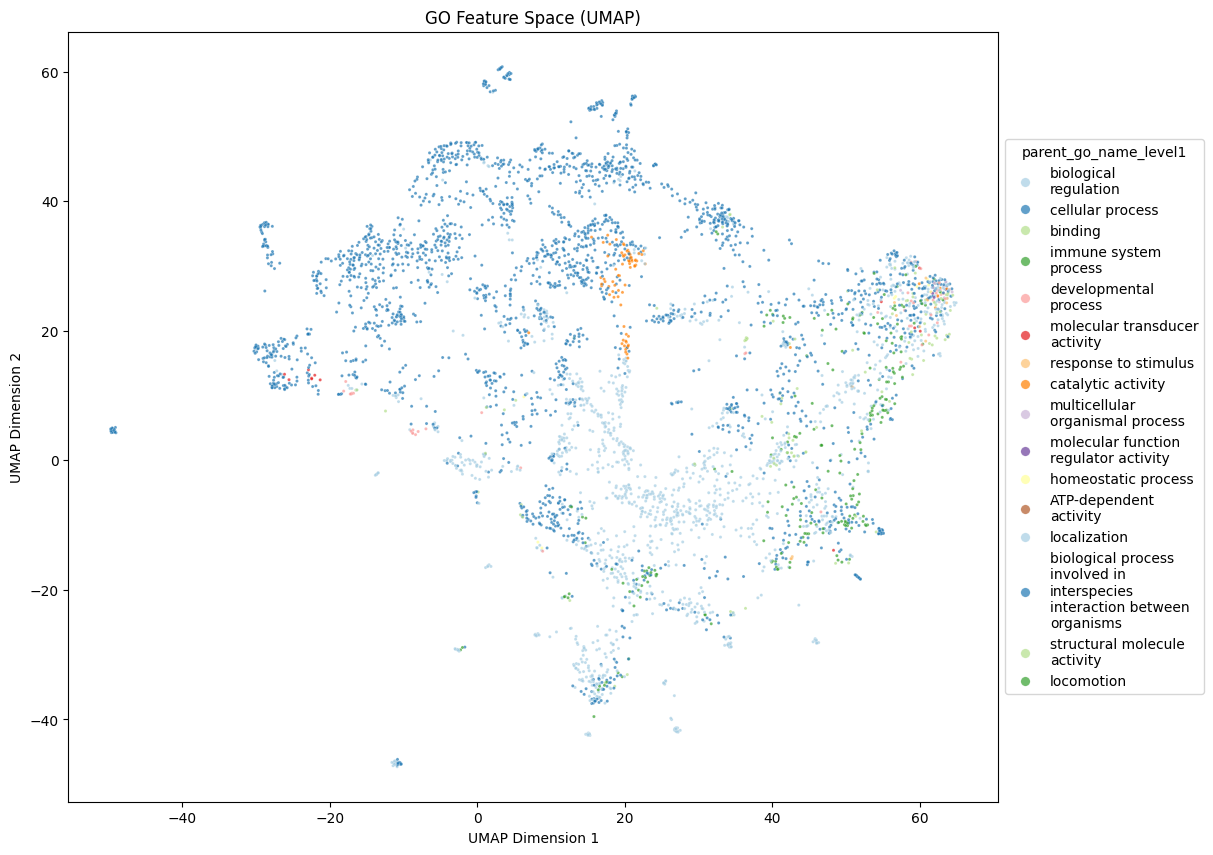

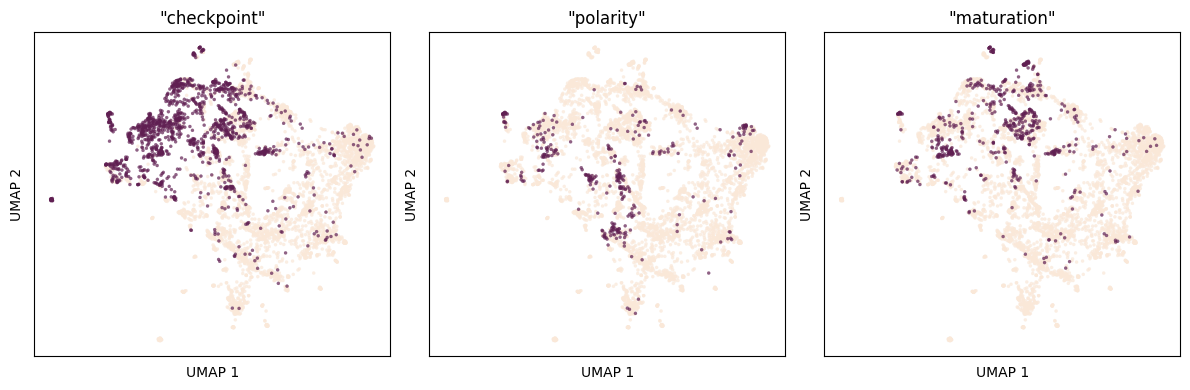

In [3]:
# load GO term analysis results
go_df = pd.read_csv(os.path.join(reports_dir, results_name))
go_df = go_df[(go_df['n_hits'] >= 1) & (go_df['mw_pval'] <= 0.01)] # restrict significance
print(f"Loaded GO analysis with {len(go_df)} rows")
    
# Path to GO OBO file
obo_file_path = os.path.join(data_dir, "go-basic.obo")

if not os.path.exists(obo_file_path):
    print("GO OBO file not found, downloading...")
    import urllib.request
    urllib.request.urlretrieve(
        "http://purl.obolibrary.org/obo/go/go-basic.obo", 
        obo_file_path
    )
    
# Add parent GO terms
go_df = add_parent_go_terms(go_df, obo_file_path)

# Visualize GO feature space
fig, ax, df_plot, go_feature_matrix, reducer = visualize_go_feature_space(
    go_df=go_df,
    activations=activations,
    obo_file_path=obo_file_path,
    method='umap',
    n_neighbors=20,
    min_dist=0.5,
    random_state=0,
    spread=10,
    figsize=(12, 10),
    output_path=os.path.join(figures_dir, "go_feature_space.png"),
    color_by='parent_go_name_level1'
)
plt.show()

# Probe GO terms with specific keywords
probe_terms = ["checkpoint", "polarity", "maturation"]

fig = probe_go_terms(
    go_df=go_df,
    activations=activations,
    terms=probe_terms,
    n_cols=3,
    output_path=os.path.join(figures_dir, "go_term_probing.png"),
    reducer=reducer,
    go_feature_matrix=go_feature_matrix
)

plt.show()

## 5. Feature Perturbation and Visualization

Let's predict how perturbing a specific feature affects the embedding space.

Perturbing top differential feature: 4525


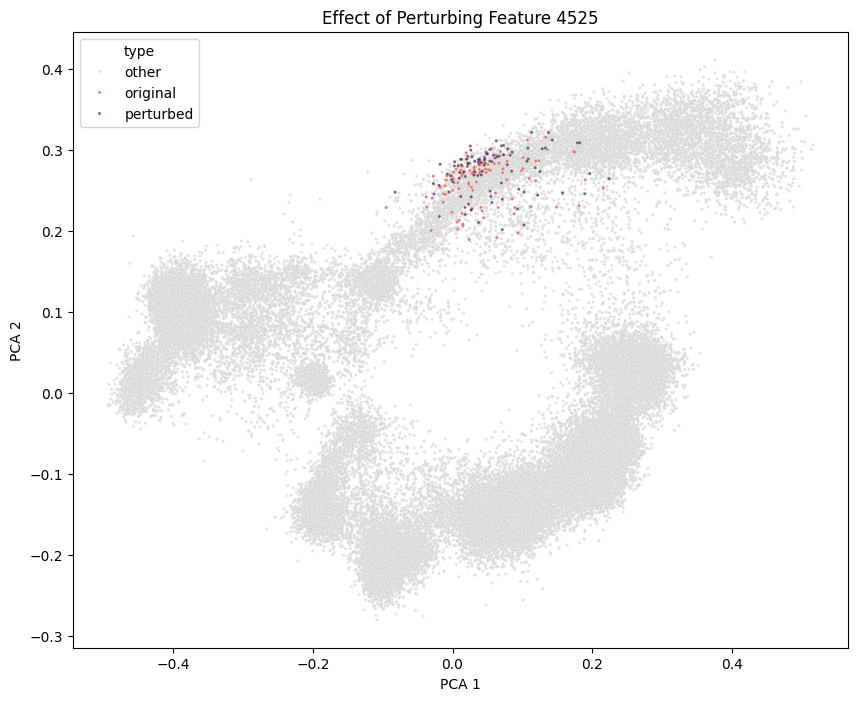

In [5]:
# Choose a feature to perturb
feature_to_perturb = int(diff_features.iloc[0]['feature'])
print(f"Perturbing top differential feature: {feature_to_perturb}")

# Choose cells to perturb (e.g., from group1)
cells_to_perturb = group1_indices[:100]  # Perturb the first 50 cells from group1

# Visualize the perturbation
fig, ax, df_plot = visualize_feature_perturbation(
    embeddings=embeddings,
    cell_indices=cells_to_perturb,
    feature_idx=feature_to_perturb,
    sae_model=sae_model,
    activations=activations,
    target_percentile=95,  # Set activation to 95th percentile
    method='pca',
    figsize=(10, 8),
    random_state=42,
    device=device,
    output_path=os.path.join(figures_dir, f"feature_{feature_to_perturb}_perturbation.png")
)

plt.show()

## 6. Investigating Specific Features of Interest

If we've identified features from GO analysis or differential analysis, we can investigate them further.

In [7]:
# load GO term analysis results
go_df = pd.read_csv(os.path.join(reports_dir, results_name))
go_df = go_df[(go_df['n_hits'] >= 1) & (go_df['mw_pval'] <= 0.01)] # restrict significance
print(f"Loaded GO analysis with {len(go_df)} rows")
    
# Path to GO OBO file
obo_file_path = os.path.join(data_dir, "go-basic.obo")

if not os.path.exists(obo_file_path):
    print("GO OBO file not found, downloading...")
    import urllib.request
    urllib.request.urlretrieve(
        "http://purl.obolibrary.org/obo/go/go-basic.obo", 
        obo_file_path
    )

Loaded GO analysis with 418394 rows


Found 327 features associated with differentiation
Investigating feature [  17 8248 8257   98  132]


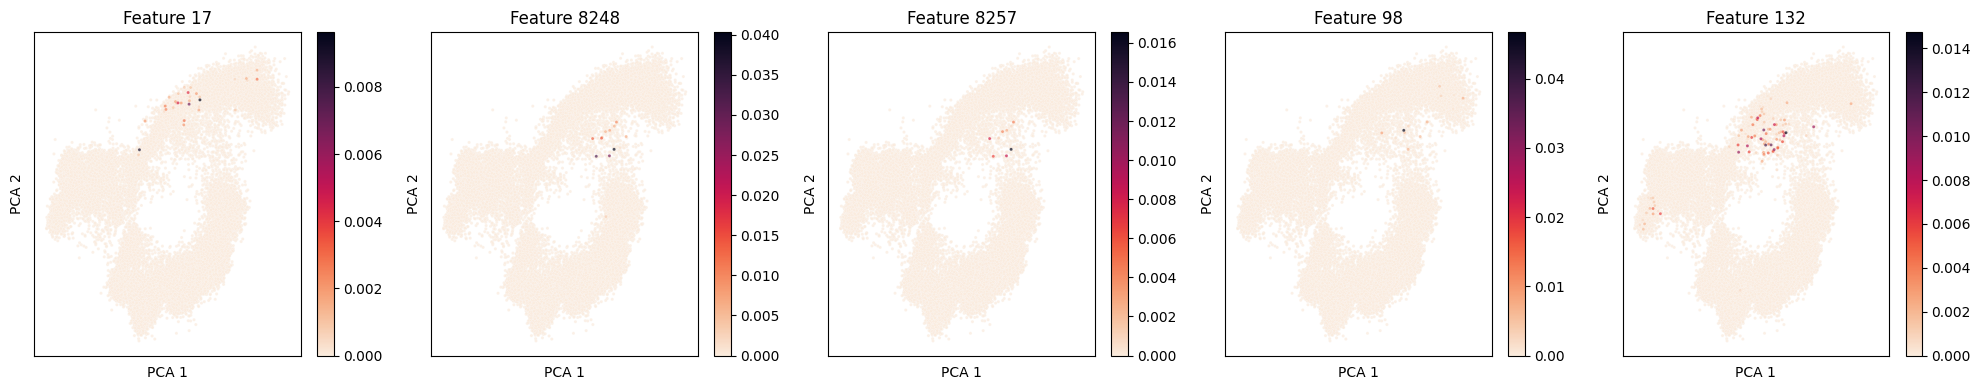

Perturbed 100 cells with feature 132
Original embedding shape: torch.Size([56714, 20])
Perturbed subset shape: torch.Size([100, 20])


In [17]:
# If GO analysis is available, find features associated with specific terms
# Example: Find features associated with differentiation
differentiation_features = go_df[go_df['go_name'].str.contains('death', case=False)]['feature'].unique()
n_features = min(len(differentiation_features), 5)

if len(differentiation_features) > 0:
    diff_feature = differentiation_features[:n_features]
    print(f"Found {len(differentiation_features)} features associated with differentiation")
    print(f"Investigating feature {diff_feature}")
    
    # Visualize the differentiation feature
    fig, ax, df_plot = visualize_feature_in_embedding(
        embeddings=embeddings,
        feature_idx=diff_feature,
        activations=activations,
        method='pca',
        #title=f"Differentiation Feature {diff_feature}",
        #figsize=(6, 4),
        cmap='rocket_r',
        random_state=42,
        device=device
    )
    
    plt.show()
    
    # Predict embedding changes with this feature
    perturbed_embeddings = predict_embedding_change(
        embeddings=embeddings,
        cell_indices=cells_to_perturb,
        feature_idx=diff_feature[-1],
        sae_model=sae_model,
        activations=activations,
        target_percentile=95,
        device=device
    )
        
    print(f"Perturbed {len(cells_to_perturb)} cells with feature {diff_feature[-1]}")
    print(f"Original embedding shape: {embeddings.shape}")
    print(f"Perturbed subset shape: {perturbed_embeddings.shape}")